# Determining the sparsity cutoff that produces the highest number of rejected hypotheses (alternative to DESeq2's independent filtering)

* Based on best cutoff, may needed to re-do the phyloseq dataset partitioning (prior notebook)
* Using multiple 'heavy' BD windows for the DESeq2 analysis
  * 1 DESeq2 run per window
  * combining DESeq2 results
  * global adjustment of P-values

# Setting variables

In [1]:
workDir = '/home/chantal/Chazy/Chazy_SIP/data/Replicates'
figDir = '/home/chantal/Chazy/Chazy_SIP/data/figs/'

physeqDir = '/home/chantal/Chazy/data/phyloseq/'
physeqFile = 'SIP_unk'


# l2fc params
l2fc_threshold = 0.25
BD_windows = ['1.70-1.73', '1.72-1.75', '1.74-1.77']
padj_cutoff = 0.1

# misc
nprocs = 20

# Init

In [2]:
import os
%load_ext rpy2.ipython
#%load_ext pushnote

In [3]:
%%R
library(DESeq2)
library(phyloseq)
library(grid); library(gridExtra)
library(plyr); library(dplyr)
library(tidyr)
library(ggplot2)
library(doParallel)
library(foreach)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: S4Vectors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: stats4

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: BiocGenerics

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: parallel

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘BiocGenerics’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/funct

In [4]:
if not os.path.isdir(workDir):
    os.makedirs(workDir)
    
if not os.path.isdir(figDir):
    os.makedirs(figDir)    

In [5]:
%%R -i l2fc_threshold -i BD_windows -i nprocs -i padj_cutoff

cat('Params loaded in R\n')

Params loaded in R


# Loading phyloseq

In [6]:
%%R -i physeqDir -i physeqFile 

F = file.path(physeqDir, physeqFile)
physeq = readRDS(F)
physeq.m = physeq %>% sample_data

physeq = prune_samples(physeq.m$Day == 3 & physeq.m$Treatment != '13C', physeq) 

physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 23345 taxa and 288 samples ]
sample_data() Sample Data:       [ 288 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 23345 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 23345 tips and 23344 internal nodes ]


## MW-HR-SIP

In [7]:
%%R
# check on number of gradients

n.gradient = physeq %>% sample_data %>% as.matrix %>% as.data.frame %>%
            distinct(Day, Treatment, Land_Management, Replicate) %>% nrow
cat('Number of gradients:', n.gradient, '\n')

Number of gradients: 12 


In [8]:
%%R
head(physeq %>% sample_data)

Sample Data:        [6 samples by 25 sample variables]:
                              Full.sample Fraction PrimerF PrimerR Barcode
12C.NTH.D3.R4.Frac28 12C.NTH.D3.R4.Frac28       28    515f    806r     174
12C.NTH.D3.R4.Frac22 12C.NTH.D3.R4.Frac22       22    515f    806r     168
13X.NTH.D3.R4.Frac28 13X.NTH.D3.R4.Frac28       28    515f    806r      48
12C.PTH.D3.R4.Frac9   12C.PTH.D3.R4.Frac9        9    515f    806r     180
12C.NTH.D3.R4.Frac16 12C.NTH.D3.R4.Frac16       16    515f    806r     162
13X.NTH.D3.R4.Frac21 13X.NTH.D3.R4.Frac21       21    515f    806r      41
                     Rev.index Fwd.index Treatment Day Replicate Pool
12C.NTH.D3.R4.Frac28  gtctgcta  tcgacgag       12C   3         4    1
12C.NTH.D3.R4.Frac22  actacgac  gtcagata       12C   3         4    1
13X.NTH.D3.R4.Frac28  ctgcgtag  gacaccgt       13X   3         4    1
12C.PTH.D3.R4.Frac9   gtctatga  tacgagac       12C   3         4    1
12C.NTH.D3.R4.Frac16  actacgac  cgttacta       12C   3         4    1

In [9]:
%%R
     
asNumeric = function(x) { as.numeric(as.character(x)) }

get_Ps = function(physeq.obj, l2fc_threshold, Treatment, Land_Management, Day, Replicate, 
                  sparsity_threshold, density_min, density_max){
        
    # function for calculating log2 fold change p-values
    Treatment = c(Treatment %>% as.character)
    physeq.md = sample_data(physeq.obj)
    
    # filtering
    p.12C = prune_samples((! is.na(physeq.md$Density)) &
                          (physeq.md$Treatment == "12C") &
                          (physeq.md$Day == Day) &
                          (physeq.md$Land_Management == Land_Management),
                           physeq.obj)
    p.13C = prune_samples((! is.na(physeq.md$Density)) & 
                      (physeq.md$Treatment == Treatment) &
                      (physeq.md$Day == Day) &
                      (physeq.md$Replicate == Replicate)&
                      (physeq.md$Land_Management == Land_Management),
                      physeq.obj)
    physeq.m = merge_phyloseq(p.12C, p.13C) 
    physeq.md = sample_data(physeq.m)
    p.12C = p.13C = NULL
    
    # sparcity cutoff applied to all gradient fractions
    physeq.m = filter_taxa(physeq.m, function(x) sum(x > 0) > sparsity_threshold * length(x), TRUE)   
    
    # applying 'heavy' window pruning
    physeq.m = prune_samples((physeq.md$Density >= density_min) &
                             (physeq.md$Density <= density_max),  physeq.m)
    
    # removing 0-abundance taxa
    physeq.m = filter_taxa(physeq.m, function(x) sum(x > 0) > 0 * length(x), TRUE)
        
    # sparsity cutoff applied to just heavy fractions
    #physeq.m = filter_taxa(physeq.m, function(x) sum(x > 0) > sparsity_threshold * length(x), TRUE)
    
    # deseq
    dds = phyloseq_to_deseq2(physeq.m, ~Treatment)
    dds = DESeq(dds, quiet = TRUE, fitType = "local")
    theta = l2fc_threshold
        
    # results
    res = results(dds, independentFiltering=FALSE)
    res$OTU = rownames(res)
        
    # p-value
    beta = res$log2FoldChange
    betaSE = res$lfcSE
    p = pnorm(beta, theta, betaSE, lower.tail=FALSE)
    res$p = p
    d = data.frame(res[, c("OTU","log2FoldChange", "p")])

    # p-value adjust
    d$padj = p.adjust(p, method = "BH")
        
    # taxonomy data
    TT = physeq.m %>% tax_table %>% data.frame
    TT$OTU = rownames(TT)
    d = left_join(d, TT, c('OTU'))
        
    # setting pruning info
    d$density_min = density_min
    d$density_max = density_max
    d$sparsity_threshold = sparsity_threshold
    return(d)
}
                                                         

## Making a table of variable params for the multiple DESeq2 runs

In [10]:
%%R
# list of substrate-day-microcosm rep combinations
## no 12C-con, because it is the comparison 

sdm = physeq %>% sample_data %>% 
    filter(! is.na(Density),
           Treatment != '12C') %>%
    select(Treatment, Day, Replicate, Land_Management) %>%
    distinct() %>%
    arrange(Treatment, Day, Replicate, Land_Management) 

sdm %>% nrow %>% print
sdm %>% head(n=5)

[1] 6
  Treatment Day Replicate Land_Management
1       13X   3         2             NTH
2       13X   3         2             PTH
3       13X   3         3             NTH
4       13X   3         3             PTH
5       13X   3         4             NTH


In [11]:
%%R
# checking that there's only one microcosm replicate per treatment
sdm %>%
    group_by(Treatment, Day, Land_Management) %>%
    summarize(n_reps=n()) %>%
    group_by(n_reps) %>%
    summarize(n_treatments = n())

Source: local data frame [1 x 2]

  n_reps n_treatments
   (int)        (int)
1      3            2


In [12]:
%%R
# adding range of sparsity thresholds (all pairwise)
sdms = sdm %>%
    unite(sdm, Treatment, Day, Replicate, Land_Management, sep='___')

sdms = expand.grid(sdms$sdm,
                   BD_windows = BD_windows,
                   sparsity_threshold = seq(0.05,0.5,0.05)) %>%
    separate(Var1, c('Treatment', 'Day', 'Replicate', 'Land_Management'), sep='___') %>%
    separate(BD_windows, c('density_min', 'density_max'), sep='-')


cat('Number of pairwise combinations of variables:', sdms %>% nrow, '\n\n')
sdms %>% head(n=3) %>% print
print('-------------------')
sdms %>% tail(n=3) %>% print

Number of pairwise combinations of variables: 180 

  Treatment Day Replicate Land_Management density_min density_max
1       13X   3         2             NTH        1.70        1.73
2       13X   3         2             PTH        1.70        1.73
3       13X   3         3             NTH        1.70        1.73
  sparsity_threshold
1               0.05
2               0.05
3               0.05
[1] "-------------------"
    Treatment Day Replicate Land_Management density_min density_max
178       13X   3         3             PTH        1.74        1.77
179       13X   3         4             NTH        1.74        1.77
180       13X   3         4             PTH        1.74        1.77
    sparsity_threshold
178                0.5
179                0.5
180                0.5


## DESeq2 runs

In [13]:
%%R 
registerDoParallel(nprocs)

df.l2fc = mdply(sdms,
                get_Ps, 
                .parallel = TRUE, 
                physeq.obj = physeq,
                l2fc_threshold = l2fc_threshold) %>% tbl_df

df.l2fc %>% head(n=3) %>% as.data.frame

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:1

  Treatment Day Replicate Land_Management      OTU log2FoldChange         p
1       13X   3         2             NTH OTU.4940     -1.7255862 0.8749283
2       13X   3         2             NTH OTU.4163     -2.4052607 0.9424257
3       13X   3         2             NTH OTU.5493      0.1634132 0.5206958
  padj    Rank1           Rank2   Rank3                  Rank4 Rank5 Rank6
1    1 Bacteria __Acidobacteria __32-21 __uncultured_bacterium  <NA>  <NA>
2    1 Bacteria   __Chloroflexi  __S085 __uncultured_bacterium  <NA>  <NA>
3    1 Bacteria   __Chloroflexi  __S085 __uncultured_bacterium  <NA>  <NA>
  Rank7 Rank8 density_min density_max sparsity_threshold
1  <NA>  <NA>        1.70        1.73               0.05
2  <NA>  <NA>        1.70        1.73               0.05
3  <NA>  <NA>        1.70        1.73               0.05


In [14]:
%%R -i workDir
# saving results

outFile = paste(c(workDir, 'MWHRSIP_all-sparsity_df_Day3Reps'), collapse='/')
saveRDS(df.l2fc, outFile)

In [15]:
%pushnote 1_sparsity_cutoff DESeq2 complete

ERROR: Line magic function `%pushnote` not found.


## Summing number of rejected hypotheses per DESeq2 run

In [16]:
%%R -i workDir
# reading in results
inFile = paste(c(workDir, 'MWHRSIP_all-sparsity_df_Day3Reps'), collapse='/')
df.l2fc = readRDS(inFile)
df.l2fc$Day = reorder(df.l2fc$Day, df.l2fc$Day %>% as.numeric)

# status
df.l2fc %>% head(n=3) %>% as.data.frame

  Treatment Day Replicate Land_Management      OTU log2FoldChange         p
1       13X   3         2             NTH OTU.4940     -1.7255862 0.8749283
2       13X   3         2             NTH OTU.4163     -2.4052607 0.9424257
3       13X   3         2             NTH OTU.5493      0.1634132 0.5206958
  padj    Rank1           Rank2   Rank3                  Rank4 Rank5 Rank6
1    1 Bacteria __Acidobacteria __32-21 __uncultured_bacterium  <NA>  <NA>
2    1 Bacteria   __Chloroflexi  __S085 __uncultured_bacterium  <NA>  <NA>
3    1 Bacteria   __Chloroflexi  __S085 __uncultured_bacterium  <NA>  <NA>
  Rank7 Rank8 density_min density_max sparsity_threshold
1  <NA>  <NA>        1.70        1.73               0.05
2  <NA>  <NA>        1.70        1.73               0.05
3  <NA>  <NA>        1.70        1.73               0.05


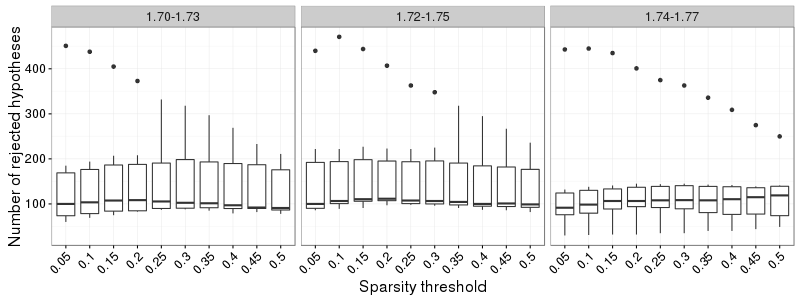

In [17]:
%%R -w 800 -h 300
df.l2fc.s = df.l2fc %>%
    unite(density_window, density_min, density_max, sep='-', remove=FALSE) %>%
    mutate(rej_hypo = padj < padj_cutoff) %>%
    group_by(density_window, sparsity_threshold, Treatment, Day, Replicate, Land_Management) %>%
    summarize(n_rej_hypo = sum(rej_hypo, na.rm=TRUE)) 


ggplot(df.l2fc.s, aes(sparsity_threshold %>% as.character, n_rej_hypo)) +
    geom_boxplot() +
    facet_wrap(~ density_window) +
    labs(x='Sparsity threshold', y='Number of rejected hypotheses') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1)
    )

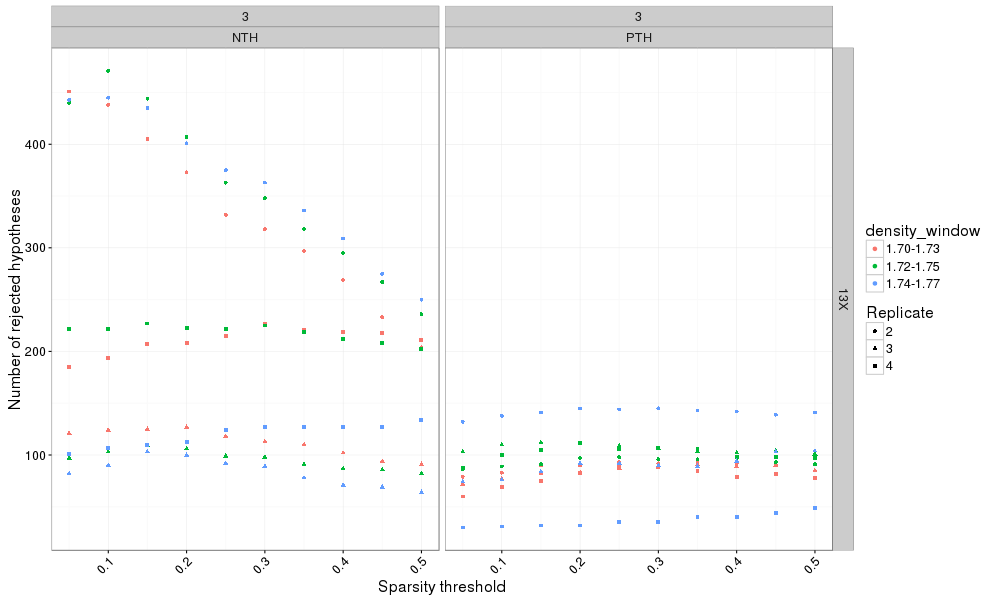

In [18]:
%%R -w 1000 -h 600
ggplot(df.l2fc.s, aes(sparsity_threshold, n_rej_hypo, color=density_window, shape = Replicate)) +
    geom_point() +
    facet_grid(Treatment ~ Day + Land_Management) +
    labs(x='Sparsity threshold', y='Number of rejected hypotheses') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1)
    )

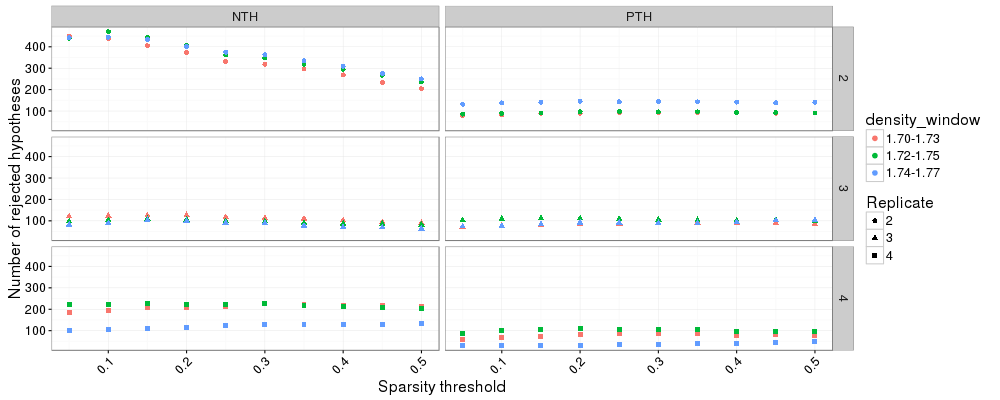

In [19]:
%%R -w 1000 -h 400

df.l2fc.s.test = df.l2fc.s 

ggplot(df.l2fc.s.test, aes(sparsity_threshold, n_rej_hypo, color=density_window, shape = Replicate)) +
    geom_point(size = 2) +
    facet_grid(Replicate ~ Land_Management) +
    labs(x='Sparsity threshold', y='Number of rejected hypotheses') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1) 
    )

### Number of taxa for each  sparsity cutoff

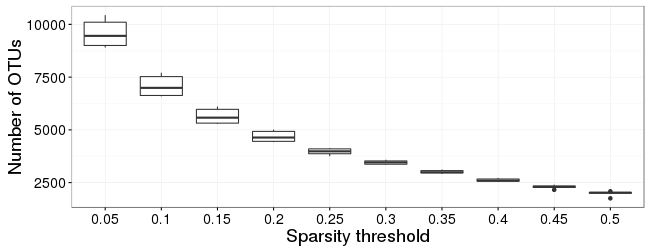

In [20]:
%%R -w 650 -h 250
# plotting number of OTUs after filtering
df.l2fc.s = df.l2fc %>%
    mutate(Day = Day %>% as.character %>% as.numeric) %>%
    group_by(Treatment, Day, Replicate, Land_Management, sparsity_threshold) %>%
    summarize(n_OTUs = OTU %>% unique %>% length) 

ggplot(df.l2fc.s, aes(sparsity_threshold %>% as.character, n_OTUs)) +
    geom_boxplot() +
    labs(x='Sparsity threshold', y='Number of OTUs') +
    theme_bw() +
    theme(
        text = element_text(size=18),
        axis.title.y = element_text(vjust=1)
        ) 

## For each treatment, selecting sparsity cutoff with most rejHypo

In [21]:
%%R
# selecting sparsity cutoffs
cat('Pre-filter:', df.l2fc %>% nrow, '\n')
df.l2fc.f = df.l2fc %>%
    group_by(Treatment, Day, Replicate, Land_Management, sparsity_threshold, density_min, density_max) %>% 
    mutate(n_rej_hypo = sum(padj < padj_cutoff, na.rm=TRUE)) %>%  # nRejHypos for each treat-spar-window combo
    group_by(Treatment, Day, Replicate, Land_Management, density_min, density_max) %>%
    filter(n_rej_hypo == max(n_rej_hypo)) %>%   # just best sparsity for treat-window combo
    ungroup() %>%
    distinct(Treatment, Day, Replicate, Land_Management, density_min, density_max, OTU) 
cat('Post-filter:', df.l2fc.f %>% nrow, '\n')

df.l2fc.f %>% head(n=3) %>% as.data.frame

Pre-filter: 785156 
Post-filter: 85657 
  Treatment Day Replicate Land_Management      OTU log2FoldChange         p
1       13X   3         2             NTH OTU.4940     -1.7255862 0.8749283
2       13X   3         2             NTH OTU.4163     -2.4052607 0.9424257
3       13X   3         2             NTH OTU.5493      0.1634132 0.5206958
  padj    Rank1           Rank2   Rank3                  Rank4 Rank5 Rank6
1    1 Bacteria __Acidobacteria __32-21 __uncultured_bacterium  <NA>  <NA>
2    1 Bacteria   __Chloroflexi  __S085 __uncultured_bacterium  <NA>  <NA>
3    1 Bacteria   __Chloroflexi  __S085 __uncultured_bacterium  <NA>  <NA>
  Rank7 Rank8 density_min density_max sparsity_threshold n_rej_hypo
1  <NA>  <NA>        1.70        1.73               0.05        451
2  <NA>  <NA>        1.70        1.73               0.05        451
3  <NA>  <NA>        1.70        1.73               0.05        451


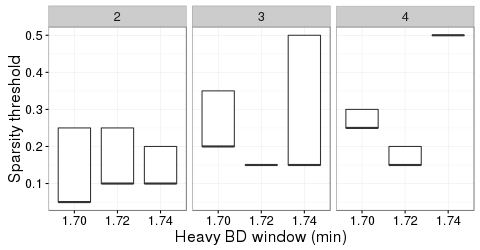

In [22]:
%%R -h 250
ggplot(df.l2fc.f, aes(density_min, sparsity_threshold)) +
    geom_boxplot() +
    labs(x='Heavy BD window (min)', y='Sparsity threshold') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    ) + facet_wrap(~Replicate)

## Global correction of p-values

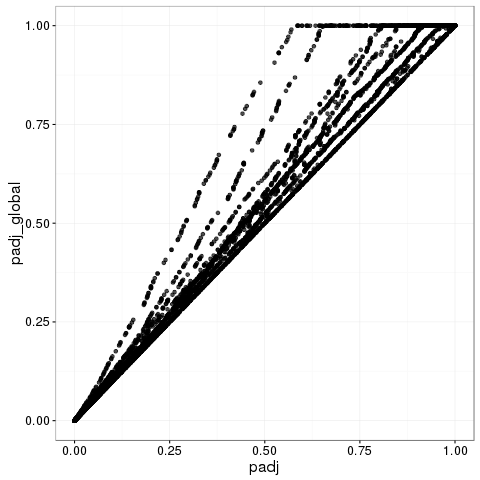

In [23]:
%%R
df.l2fc.f = df.l2fc.f %>%
    group_by(Treatment, Day, Replicate, Land_Management) %>%
    mutate(padj_global = p.adjust(p, method='BH'),
           padj_global = ifelse(padj_global < padj, padj, padj_global)) %>%
    ungroup() 

p1 = ggplot(df.l2fc.f, aes(padj, padj_global)) +
    geom_point(alpha=0.7) +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

df.l2fc.f = df.l2fc.f %>%
    mutate(padj = padj_global) %>%
    select(-padj_global)

p1

## Selecting max l2fc for each treatment-OTU

In [24]:
%%R
cat('Pre-filter:', df.l2fc.f %>% nrow, '\n')
df.l2fc.f = df.l2fc.f %>%
    group_by(Treatment, Day, Replicate, Land_Management, OTU) %>%
    filter(log2FoldChange == max(log2FoldChange, na.rm=TRUE)) %>%
    ungroup() %>%
    distinct(Treatment, Day, Replicate, Land_Management, OTU) %>%
    select(-n_rej_hypo)
cat('Post-filter:', df.l2fc.f %>% nrow, '\n')

Pre-filter: 85657 
Post-filter: 35935 


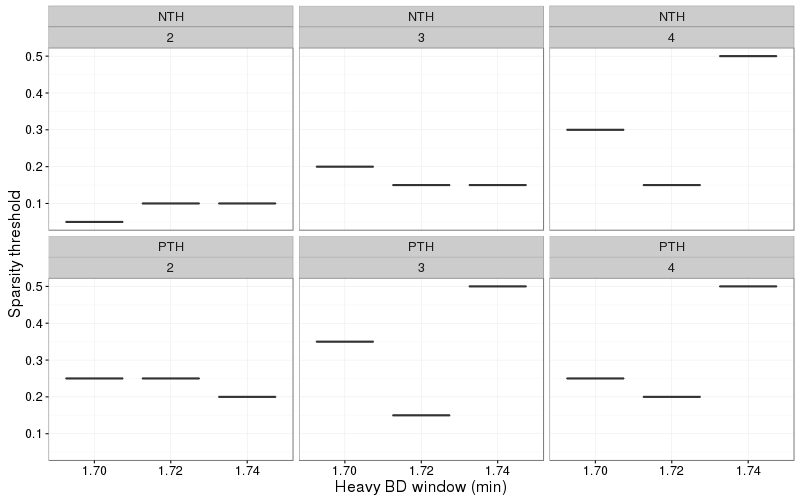

In [25]:
%%R -h 500 -w 800
ggplot(df.l2fc.f, aes(density_min, sparsity_threshold)) +
    geom_boxplot() +
    labs(x='Heavy BD window (min)', y='Sparsity threshold') +
    theme_bw() +
    theme(
        text = element_text(size=16) 
    ) + facet_wrap(Land_Management ~ Replicate)

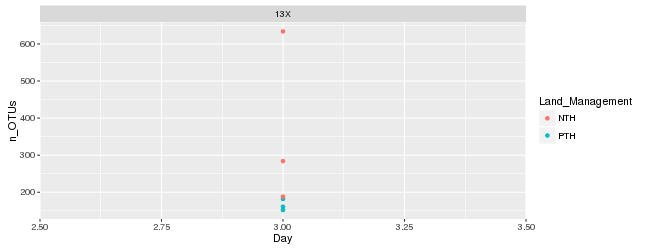

In [26]:
%%R -w 650 -h 250
# plotting number of OTUs after filtering
df.l2fc.f.s = df.l2fc.f %>%
    mutate(Day = Day %>% as.character %>% as.numeric) %>% filter(padj <=0.10) %>%
    group_by(Treatment, Day, Replicate, Land_Management) %>%
    summarize(n_OTUs = n()) 

ggplot(df.l2fc.f.s, aes(Day, n_OTUs, color=Land_Management, group=Replicate)) +
    geom_point()  + facet_wrap(~Treatment)
    #geom_line()

In [27]:
%%R
# checking that there's only 1 OTU value per treatment
df.l2fc.f %>%
    group_by(Treatment, Day, Replicate, Land_Management, sparsity_threshold, OTU) %>%
    summarize(n = n()) %>%
    ungroup %>%
    filter(n > 1) %>% as.data.frame

[1] Treatment          Day                Replicate          Land_Management   
[5] sparsity_threshold OTU                n                 
<0 rows> (or 0-length row.names)


In [28]:
%%R -i workDir
# Writing out l2fc table

outFile = file.path(workDir, 'l2fc_sparse-maxRejH_Day3Reps.txt')
write.table(df.l2fc.f, outFile, sep='\t', quote=FALSE, row.names=FALSE)

In [22]:
%%R
df.l2fc.f = read.table('data/Replicates/l2fc_sparse-maxRejH_Day3Reps.txt', header = TRUE)

In [23]:
%%R
head(df.l2fc.f)

  Treatment Day Replicate Land_Management      OTU log2FoldChange         p
1       13X   3         2             NTH OTU.5493      0.1634132 0.5206958
2       13X   3         2             NTH OTU.1739     -1.9912249 0.8659410
3       13X   3         2             NTH OTU.1813     -0.6586639 0.6585394
4       13X   3         2             NTH  OTU.778     -1.3900404 0.9996524
5       13X   3         2             NTH OTU.5511     -0.2685305 0.5956205
6       13X   3         2             NTH OTU.6957     -0.2791083 0.5970621
  padj    Rank1            Rank2          Rank3                  Rank4 Rank5
1    1 Bacteria    __Chloroflexi         __S085 __uncultured_bacterium  <NA>
2    1 Bacteria __Planctomycetes        __OM190 __uncultured_bacterium  <NA>
3    1 Bacteria __Planctomycetes        __OM190 __uncultured_bacterium  <NA>
4    1 Bacteria __Planctomycetes __Pla4_lineage __uncultured_bacterium  <NA>
5    1 Bacteria __Planctomycetes __Pla4_lineage __uncultured_bacterium  <NA>
6    1

# Plotting the results

In [24]:
%%R
resp_num = filter(df.l2fc.f, padj <=0.10)
print(length(resp_num$OTU))
print(length(unique(resp_num$OTU)))

[1] 1601
[1] 1050


In [25]:
%%R
df.l2fc.f %>% filter(padj <=0.10) %>% group_by(Replicate) %>% summarise(resp = length(unique(OTU)))

Source: local data frame [3 x 2]

  Replicate  resp
      (int) (int)
1         2   694
2         3   319
3         4   379


In [26]:
%%R
resps = df.l2fc.f %>% filter(padj <=0.10) %>% group_by(Replicate, Land_Management) %>% 
            summarise(resp = length(unique(OTU)))
resps

Source: local data frame [6 x 3]
Groups: Replicate [?]

  Replicate Land_Management  resp
      (int)          (fctr) (int)
1         2             NTH   634
2         2             PTH   182
3         3             NTH   188
4         3             PTH   161
5         4             NTH   284
6         4             PTH   152


In [27]:
%%R
N = resps %>% filter(Land_Management == 'NTH')
P = resps %>% filter(Land_Management == 'PTH')

print(summary(N$resp))
print(sd(N$resp))

print(summary(P$resp))
print(sd(P$resp))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  188.0   236.0   284.0   368.7   459.0   634.0 
[1] 234.7453
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  152.0   156.5   161.0   165.0   171.5   182.0 
[1] 15.3948


In [28]:
%%R
Rep2.N = filter(df.l2fc.f, Replicate ==2, padj <=0.10, Land_Management == 'NTH')
Rep3.N = filter(df.l2fc.f, Replicate ==3, padj <=0.10, Land_Management == 'NTH')
Rep4.N = filter(df.l2fc.f, Replicate ==4, padj <=0.10, Land_Management == 'NTH')

Rep2.P = filter(df.l2fc.f, Replicate ==2, padj <=0.10, Land_Management == 'PTH')
Rep3.P = filter(df.l2fc.f, Replicate ==3, padj <=0.10, Land_Management == 'PTH')
Rep4.P = filter(df.l2fc.f, Replicate ==4, padj <=0.10, Land_Management == 'PTH')

In [29]:
%%R
print(length(intersect(Rep2.N$OTU, Rep3.N$OTU)))
print(length(intersect(Rep2.N$OTU, Rep4.N$OTU)))
print(length(intersect(Rep3.N$OTU, Rep4.N$OTU)))

print(length(intersect(Rep2.P$OTU, Rep3.P$OTU)))
print(length(intersect(Rep2.P$OTU, Rep4.P$OTU)))
print(length(intersect(Rep3.P$OTU, Rep4.P$OTU)))

[1] 16
[1] 95
[1] 40
[1] 84
[1] 72
[1] 67


In [30]:
%%R
print(length(intersect(Rep2.N$OTU, Rep3.N$OTU))/length(union(Rep2.N$OTU, Rep3.N$OTU)))
print(length(intersect(Rep2.N$OTU, Rep4.N$OTU))/length(union(Rep2.N$OTU, Rep4.N$OTU)))
print(length(intersect(Rep3.N$OTU, Rep4.N$OTU))/length(union(Rep3.N$OTU, Rep4.N$OTU)))

print(length(intersect(Rep2.P$OTU, Rep3.P$OTU))/length(union(Rep2.P$OTU, Rep3.P$OTU)))
print(length(intersect(Rep2.P$OTU, Rep4.P$OTU))/length(union(Rep2.P$OTU, Rep4.P$OTU)))
print(length(intersect(Rep3.P$OTU, Rep4.P$OTU))/length(union(Rep3.P$OTU, Rep4.P$OTU)))

[1] 0.01985112
[1] 0.1154313
[1] 0.09259259
[1] 0.3243243
[1] 0.2748092
[1] 0.2723577


In [31]:
%%R
print(mean(c(16,95,40)))
print(sd(c(16,95,40)))

print(mean(c(84,72,67)))
print(sd(c(84,72,67)))

[1] 50.33333
[1] 40.50103
[1] 74.33333
[1] 8.736895


In [32]:
%%R
length(Reduce(intersect, list(Rep2$OTU, Rep3$OTU, Rep4$OTU)))


Error in Reduce(intersect, list(Rep2$OTU, Rep3$OTU, Rep4$OTU)) : 
  object 'Rep2' not found


In [33]:
%%R
length(Reduce(intersect, list(Rep2.N$OTU, Rep3.N$OTU, Rep4.N$OTU, Rep2.P$OTU, Rep3.P$OTU, Rep4.P$OTU)))

[1] 6


## l2fc plot

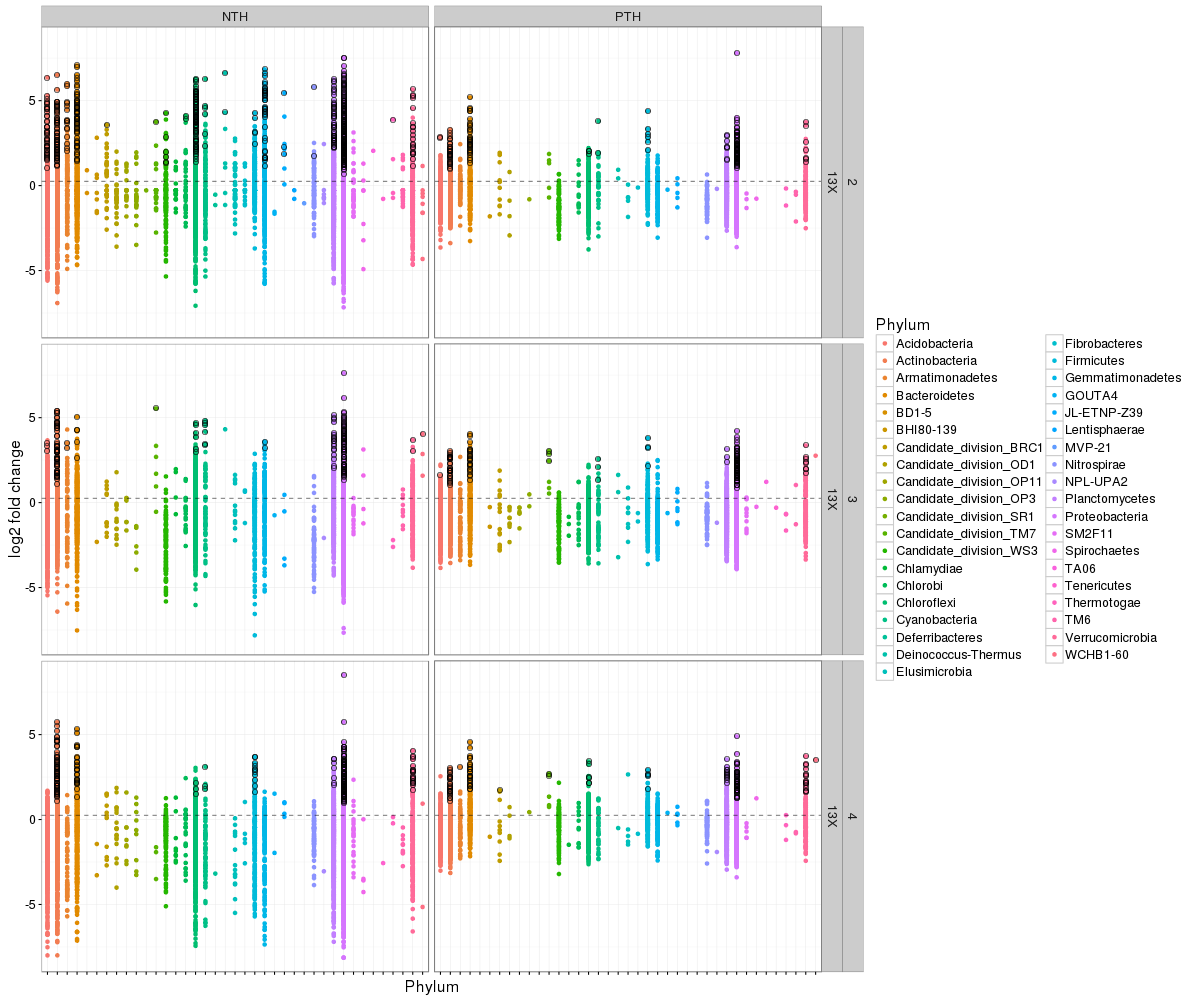

In [34]:
%%R -w 1200 -h 1000

df.l2fc.f = df.l2fc.f %>%
    mutate(Rank2 = gsub('^__', '', Rank2))

df.l2fc.f.sig = df.l2fc.f %>%
    filter(padj < padj_cutoff) %>%
    mutate(Rank2 = gsub('^__', '', Rank2))

p.l2fc = ggplot(df.l2fc.f, aes(Rank2, color=Rank2)) +
    geom_point(aes(y=log2FoldChange)) +
    geom_point(data=df.l2fc.f.sig, aes(y=log2FoldChange), shape='O', color='black', alpha=0.8, size=2.5) +
    geom_hline(yintercept=l2fc_threshold, alpha=0.5, linetype='dashed') +
    facet_grid(Treatment ~ Replicate ~ Land_Management) +
    scale_color_discrete('Phylum') +
    labs(x = 'Phylum', y='log2 fold change') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_blank()
        )
p.l2fc

In [35]:
%%R
ggsave('data/figs/D3Xyl_Reps.jpg', width = 12, height = 8)

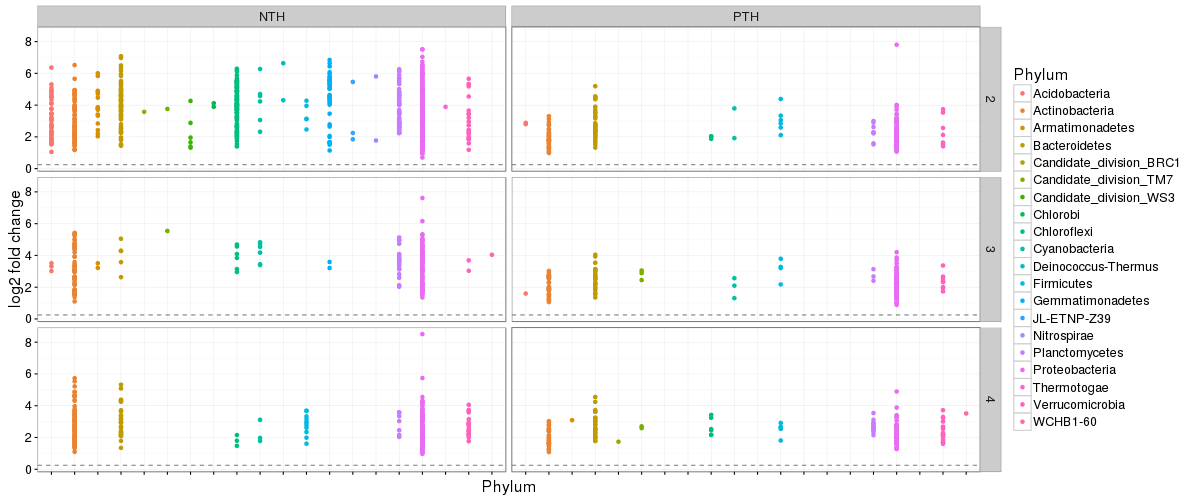

In [36]:
%%R -w 1200 -h 500
#Just significant OTUs...

df.l2fc.f = df.l2fc.f %>%
    mutate(Rank2 = gsub('^__', '', Rank2))

df.l2fc.f.sig = df.l2fc.f %>%
    filter(padj < padj_cutoff) %>%
    mutate(Rank2 = gsub('^__', '', Rank2))

p.l2fc = ggplot(df.l2fc.f.sig, aes(Rank2, color=Rank2)) +
    geom_point(aes(y=log2FoldChange)) +
    #geom_point(data=df.l2fc.f.sig, aes(y=log2FoldChange), shape='O', color='black', alpha=0.8, size=2.5) +
    geom_hline(yintercept=l2fc_threshold, alpha=0.5, linetype='dashed') +
    facet_grid(Replicate ~ Land_Management) +
    scale_color_discrete('Phylum') +
    labs(x = 'Phylum', y='log2 fold change') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_blank()
        )
p.l2fc